Dataset – The dataset under consideration contains a total of 50,000 movie reviews
obtained from the Internet Movie Database. These reviews have been divided into two
distinct sets: a training set comprising 25,000 reviews and a testing set consisting of the
remaining 25,000 reviews. It is noteworthy that the reviews are not uniformly distributed
across the entire spectrum of sentiment; rather, they are dichotomous in nature, with
half of the reviews expressing positive sentiments and the other half expressing
negative sentiments.

Task 1 – In this exercise, you will construct three distinct machine learning models

Task 2 – Compare and visualize the learning curves and performance of the three models.

Task 3 – Write a scientific report which includes


In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
!pip install contractions
import contractions
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install datasets transformers
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
!pip install fasttext
import fasttext

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#import dataset
# REPLACE YOUR CSV PATH HERE
imdb_df_org = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IMDB%20Dataset.csv")

In [4]:
# print count of all different sentiments count
print(imdb_df_org['sentiment'].value_counts())
imdb_df_org.head(50)

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Data Preprocesing

### Text Cleaning

In [5]:
imdb_df = imdb_df_org.copy()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub('<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = contractions.fix(text)  # Fix contractions
    text = re.sub(r"\s+", " ", text).strip()  # Normalize whitespace
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words and len(word) > 3])
    return text.lower()  # Lowercase conversion

imdb_df['review'] = imdb_df['review'].apply(clean_text)

### Tokenisations

In [6]:
def tokenize_text(text):
    return word_tokenize(text)

### Lemmatization

In [7]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

### Stemming

In [8]:
stemmer = PorterStemmer()

def stem_text(tokens):
    return [stemmer.stem(token) for token in tokens]

In [9]:
def preprocess_text(text):
    tokens = tokenize_text(text)
    tokens = lemmatize_text(tokens)
    tokens = stem_text(tokens)
    return ' '.join(tokens)

#  Data exploration

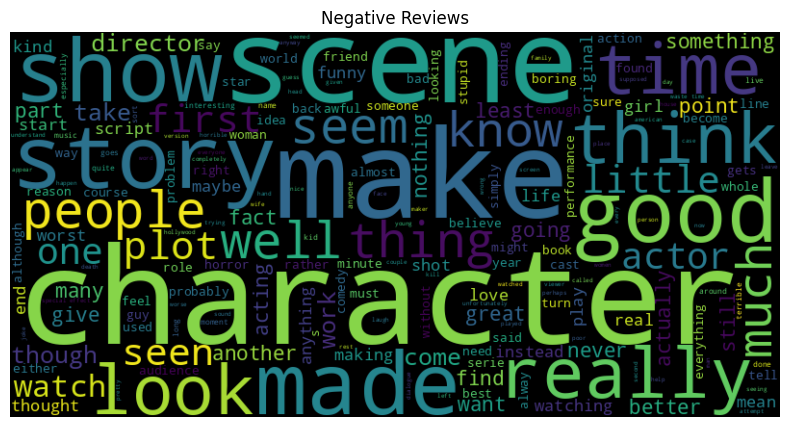

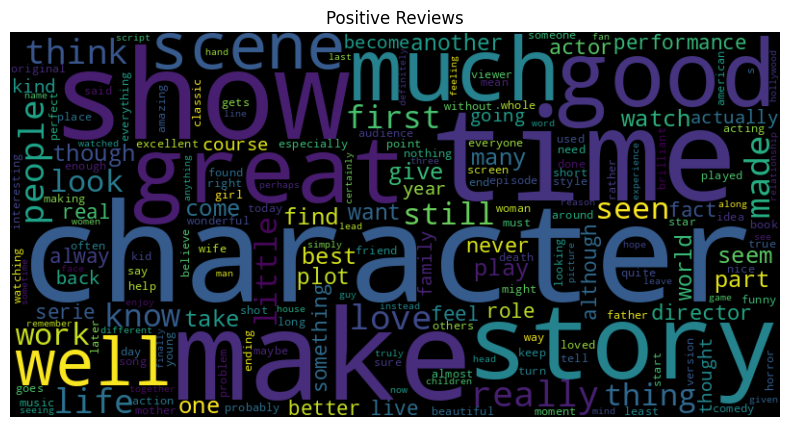

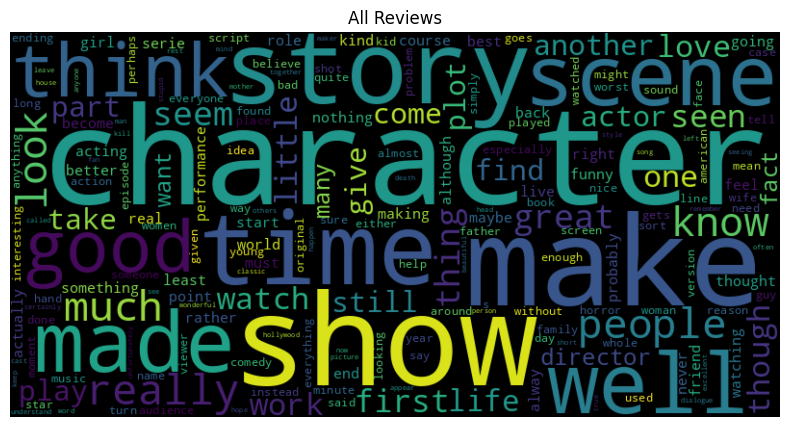

In [10]:
# Word cloud for positive, negative and all reviews
from wordcloud import WordCloud
from collections import Counter

def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()
    return wordcloud

#negative ignoring word movie & film
negative_reviews = imdb_df[imdb_df['sentiment'] == 'negative']['review']
#remove word movie, movies , film
negative_text = ' '.join(negative_reviews).replace('movies', '').replace('films', '').replace('movie', '').replace('film', '').replace('even', '')
generate_word_cloud(negative_text, 'Negative Reviews')


#positive
positive_reviews = imdb_df[imdb_df['sentiment'] == 'positive']['review']
positive_text = ' '.join(positive_reviews).replace('movies', '').replace('films', '').replace('movie', '').replace('film', '').replace('even', '')
generate_word_cloud(positive_text, 'Positive Reviews')


#all
all_reviews = imdb_df['review']
all_text = ' '.join(all_reviews).replace('movies', '').replace('films', '').replace('movie', '').replace('film', '').replace('even', '')
generate_word_cloud(all_text, 'All Reviews')

# Model Training

In [11]:
imdb_df_processed = imdb_df.copy()

#preprocess text
train_texts = imdb_df_processed['review'].apply(preprocess_text)
train_labels = imdb_df_processed['sentiment']

### 1) Naive Bayes



In [12]:
nb_pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1,2), max_features=10000), MultinomialNB())
#train test split
NB_X_train, NB_X_test, NB_y_train, NB_y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

#train model
nb_pipeline.fit(NB_X_train, NB_y_train)

#predict
nb_predictions = nb_pipeline.predict(NB_X_test)

#evaluate
nb_accuracy = accuracy_score(NB_y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)
print(classification_report(NB_y_test, nb_predictions))

Naive Bayes Accuracy: 0.8629
              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      4961
    positive       0.86      0.87      0.87      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



### 2) SVM

In [13]:
svm_pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
    SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3)
)

#train test split
SVM_X_train, SVM_X_test, SVM_y_train, SVM_y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

#train
svm_pipeline.fit(SVM_X_train, SVM_y_train)

#predict
svm_predictions = svm_pipeline.predict(SVM_X_test)

#evaluate
svm_accuracy = accuracy_score(SVM_y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)
print(classification_report(SVM_y_test, svm_predictions))


SVM Accuracy: 0.8878
              precision    recall  f1-score   support

    negative       0.90      0.87      0.89      4961
    positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### BERT (Ignore this model as this takes lot of time training approx 26hrs)

In [14]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

def tokenize_function(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True, max_length=64)

# Convert DataFrame to Dataset
dataset = Dataset.from_pandas(imdb_df)

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Convert 'sentiment' to numerical labels before renaming the column
tokenized_datasets = tokenized_datasets.map(lambda examples: {'label': [1 if sentiment == 'positive' else 0 for sentiment in examples['sentiment']]}, batched=True)


# Set the dataset format for PyTorch
tokenized_datasets.set_format(type="torch", columns=['input_ids', 'attention_mask', 'label'])

train_test_split = tokenized_datasets.train_test_split(test_size=0.2)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

from transformers import Trainer, TrainingArguments
from torch.cuda.amp import autocast, GradScaler

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=32,  # Increase batch size
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    save_strategy="epoch",
    report_to="none",
    fp16=True  # Enable mixed precision training
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split["train"],
    eval_dataset=train_test_split["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


# Evaluate the model
bert_eval_results = trainer.evaluate()
print("BERT Evaluation Results:", bert_eval_results)

model.safetensors:  45%|####5     | 199M/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

KeyboardInterrupt: 

### FastText

In [15]:
#Train the model using fasttext

# Save training and test data to text files in the required FastText format
train_file = "train.txt"
test_file = "test.txt"

imdb_df_processed = imdb_df.copy()
imdb_df_processed['review'] = train_texts


with open(train_file, "w") as f_train, open(test_file, "w") as f_test:
    for i, row in imdb_df_processed.iterrows():
        label = "__label__" + row['sentiment']
        line = f"{label} {row['review']}\n"
        if i % 5 == 0:  # 20% test split
            f_test.write(line)
        else:
            f_train.write(line)

#Train the model
model = fasttext.train_supervised(input=train_file, epoch=25, lr=0.1, wordNgrams=2)

# Predict on the test data
labels, probabilities = model.predict(list(imdb_df_processed['review'][imdb_df_processed.index % 5 == 0]))

# Convert labels and sentiment to numeric (1 for positive, 0 for negative)
predicted_labels = [1 if label[0] == '__label__positive' else 0 for label in labels]
actual_labels = [1 if sentiment == 'positive' else 0 for sentiment in imdb_df_processed['sentiment'][imdb_df_processed.index % 5 == 0]]

# Calculate accuracy
correct_predictions = sum(p == a for p, a in zip(predicted_labels, actual_labels))
total_predictions = len(predicted_labels)
accuracy = correct_predictions / total_predictions

#Test the model
result = model.test(test_file)
ft_accuracy = result[1]


#Evaluate
print("FastText Accuracy:", accuracy)
print("FastText Precision:", result[1])




FastText Accuracy: 0.8979
FastText Precision: 0.8979


# Visualise performance

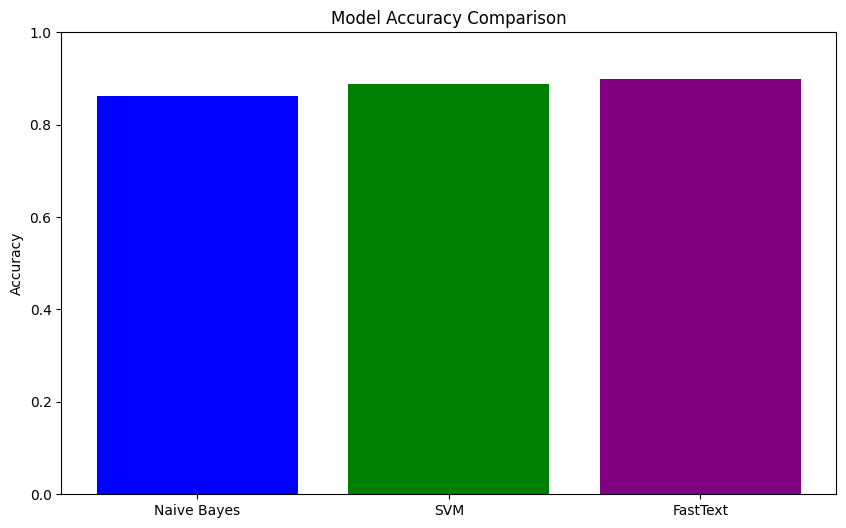

In [16]:
# Plotting accuracy comparison
models = ['Naive Bayes', 'SVM', 'FastText']
accuracies = [nb_accuracy, svm_accuracy, ft_accuracy]
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'purple'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

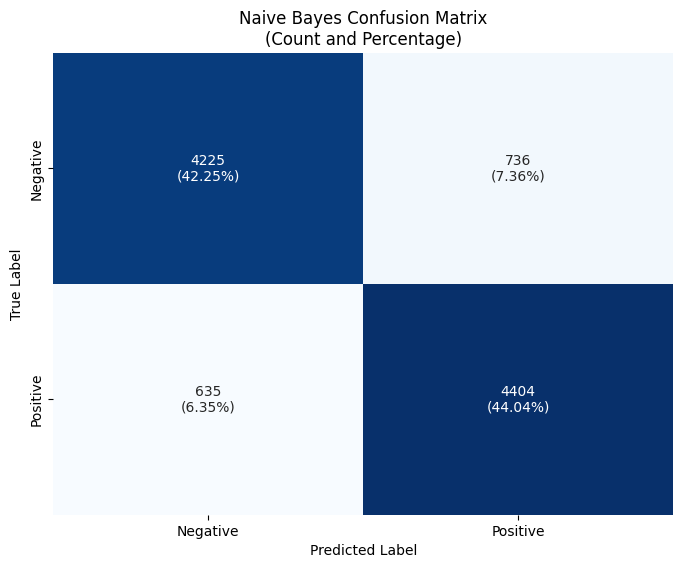

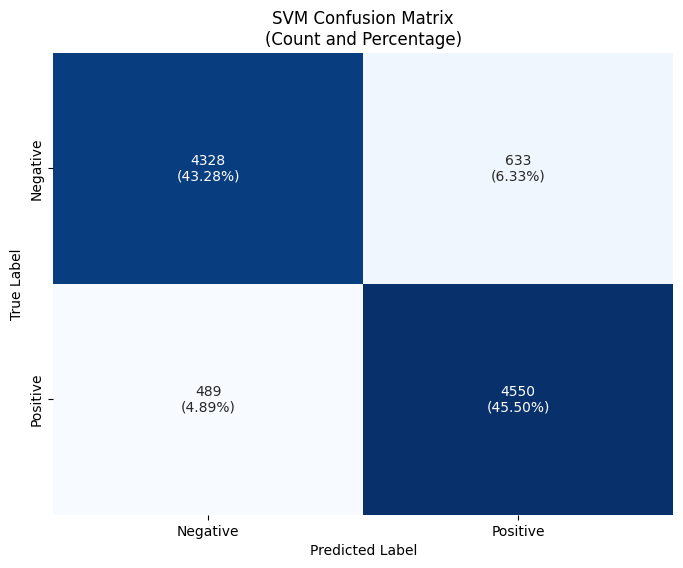

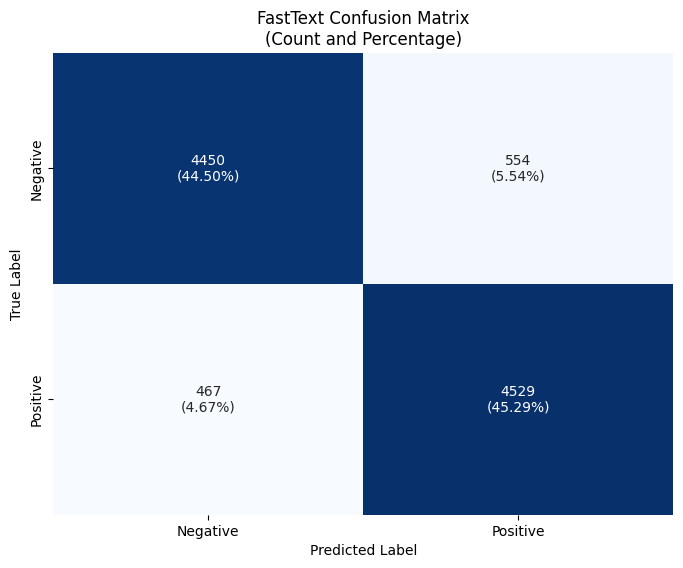

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to calculate and plot confusion matrix with count and percentage
def plot_confusion_matrix_with_count_and_percentage(cm, labels, model_name):
    cm_percentage = cm / 10000 * 100

    annotations = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percentage = cm_percentage[i, j]
            row.append(f'{count}\n({percentage:.2f}%)')
        annotations.append(row)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=annotations, fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(f'{model_name} Confusion Matrix\n(Count and Percentage)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Naive Bayes Confusion Matrix
nb_cm = confusion_matrix(NB_y_test, nb_predictions)
plot_confusion_matrix_with_count_and_percentage(nb_cm, ['Negative', 'Positive'], 'Naive Bayes')

#SVM
svm_cm = confusion_matrix(SVM_y_test, svm_predictions)
plot_confusion_matrix_with_count_and_percentage(svm_cm, ['Negative', 'Positive'], 'SVM')

#fasttext
ft_cm = confusion_matrix(actual_labels, predicted_labels)
plot_confusion_matrix_with_count_and_percentage(ft_cm, ['Negative', 'Positive'], 'FastText')


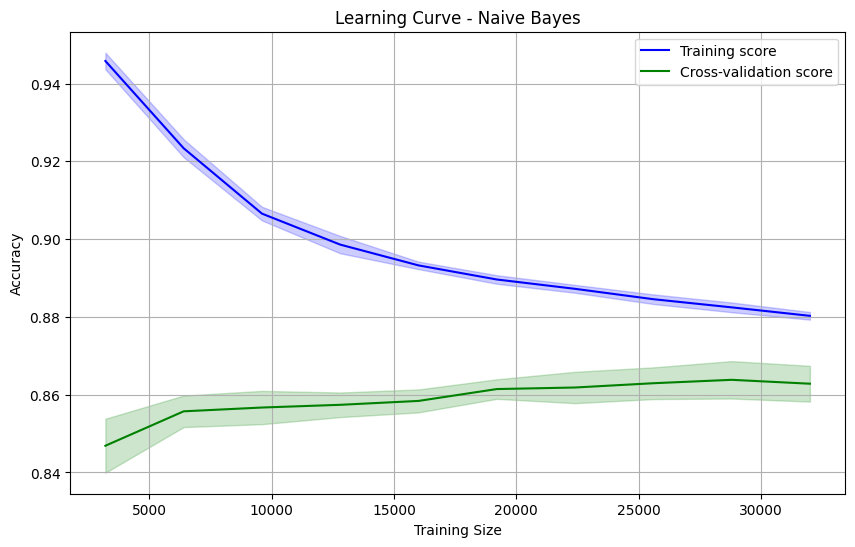

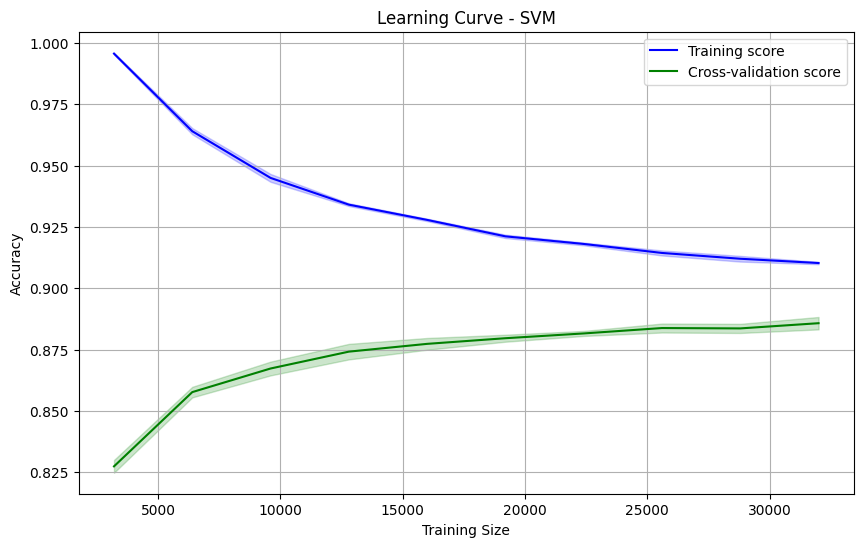

In [18]:
# Visualizing Learning Curves and Model Performance



from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, cv=5):
    """Plots learning curve for a given estimator."""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calculate mean and standard deviation
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)

    plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

    plt.title(title)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Plot learning curves for Naive Bayes & SVM
plot_learning_curve(nb_pipeline, 'Learning Curve - Naive Bayes', NB_X_train, NB_y_train)
plot_learning_curve(svm_pipeline, 'Learning Curve - SVM', SVM_X_train, SVM_y_train)





Epoch 1: Accuracy 0.8979
Epoch 2: Accuracy 0.8979
Epoch 3: Accuracy 0.8979
Epoch 4: Accuracy 0.8979
Epoch 5: Accuracy 0.8979
Epoch 6: Accuracy 0.8979
Epoch 7: Accuracy 0.8979
Epoch 8: Accuracy 0.8979
Epoch 9: Accuracy 0.8979
Epoch 10: Accuracy 0.8979
Epoch 11: Accuracy 0.8979
Epoch 12: Accuracy 0.8979
Epoch 13: Accuracy 0.8979
Epoch 14: Accuracy 0.8979
Epoch 15: Accuracy 0.8979
Epoch 16: Accuracy 0.8979
Epoch 17: Accuracy 0.8979
Epoch 18: Accuracy 0.8979
Epoch 19: Accuracy 0.8979
Epoch 20: Accuracy 0.8979
Epoch 21: Accuracy 0.8979
Epoch 22: Accuracy 0.8979
Epoch 23: Accuracy 0.8979
Epoch 24: Accuracy 0.8979
Epoch 25: Accuracy 0.8979


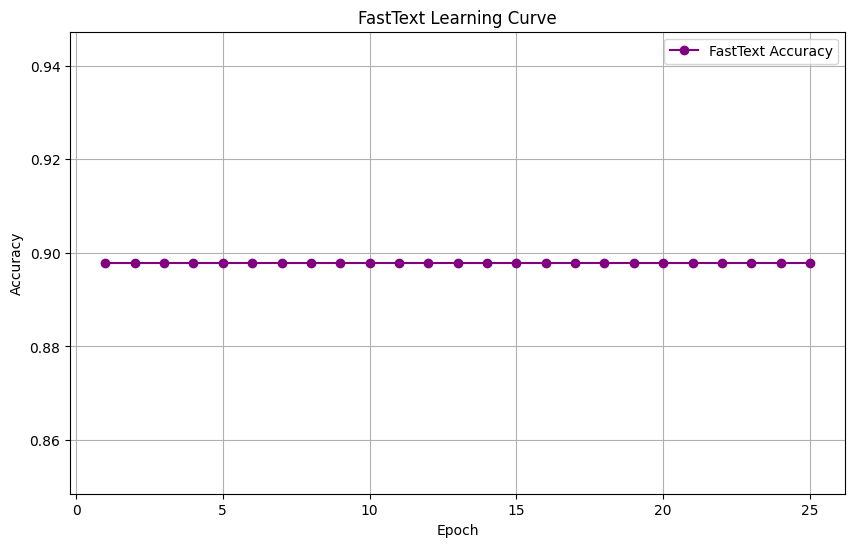

In [19]:
# FastText learning curve (accuracy over epochs)
def plot_fasttext_learning_curve(model, test_file, epochs=25):
    """Plots FastText accuracy over epochs."""
    fasttext_accuracies = []

    for epoch in range(1, epochs + 1):
        result = model.test(test_file)
        fasttext_accuracies.append(result[1])
        print(f'Epoch {epoch}: Accuracy {result[1]:.4f}')

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), fasttext_accuracies, label='FastText Accuracy', color='purple', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('FastText Learning Curve')
    plt.legend()
    plt.grid()
    plt.show()

# Plot learning curve for FastText
plot_fasttext_learning_curve(model, test_file)